In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from matplotlib import gridspec
from scipy import stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")

### Note from Junpeng Lao
In PyMC3, a discrete latent variable could be very easily expressed as a discrete random variable. PyMC3 will assign this discrete variable with a sampler (usually a Metropolis sampler), while the rest of the (continous) RVs sample with NUTS. However, care must be taken, as the correctness of mixing different sampler is in general not guaranteed. The standard treatment is integrate out the latent variables, as done in Stan.

# Chapter 6 - Latent-mixture models
## 6.1 Exam scores


Exam result consistent of 2 group of students - one group is purely guess and the other with a >.5 accuracy rate

$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \phi \sim \text{Uniform}(0.5, 1) $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

(It is also possible to estimate this model using a EM algorthim.)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


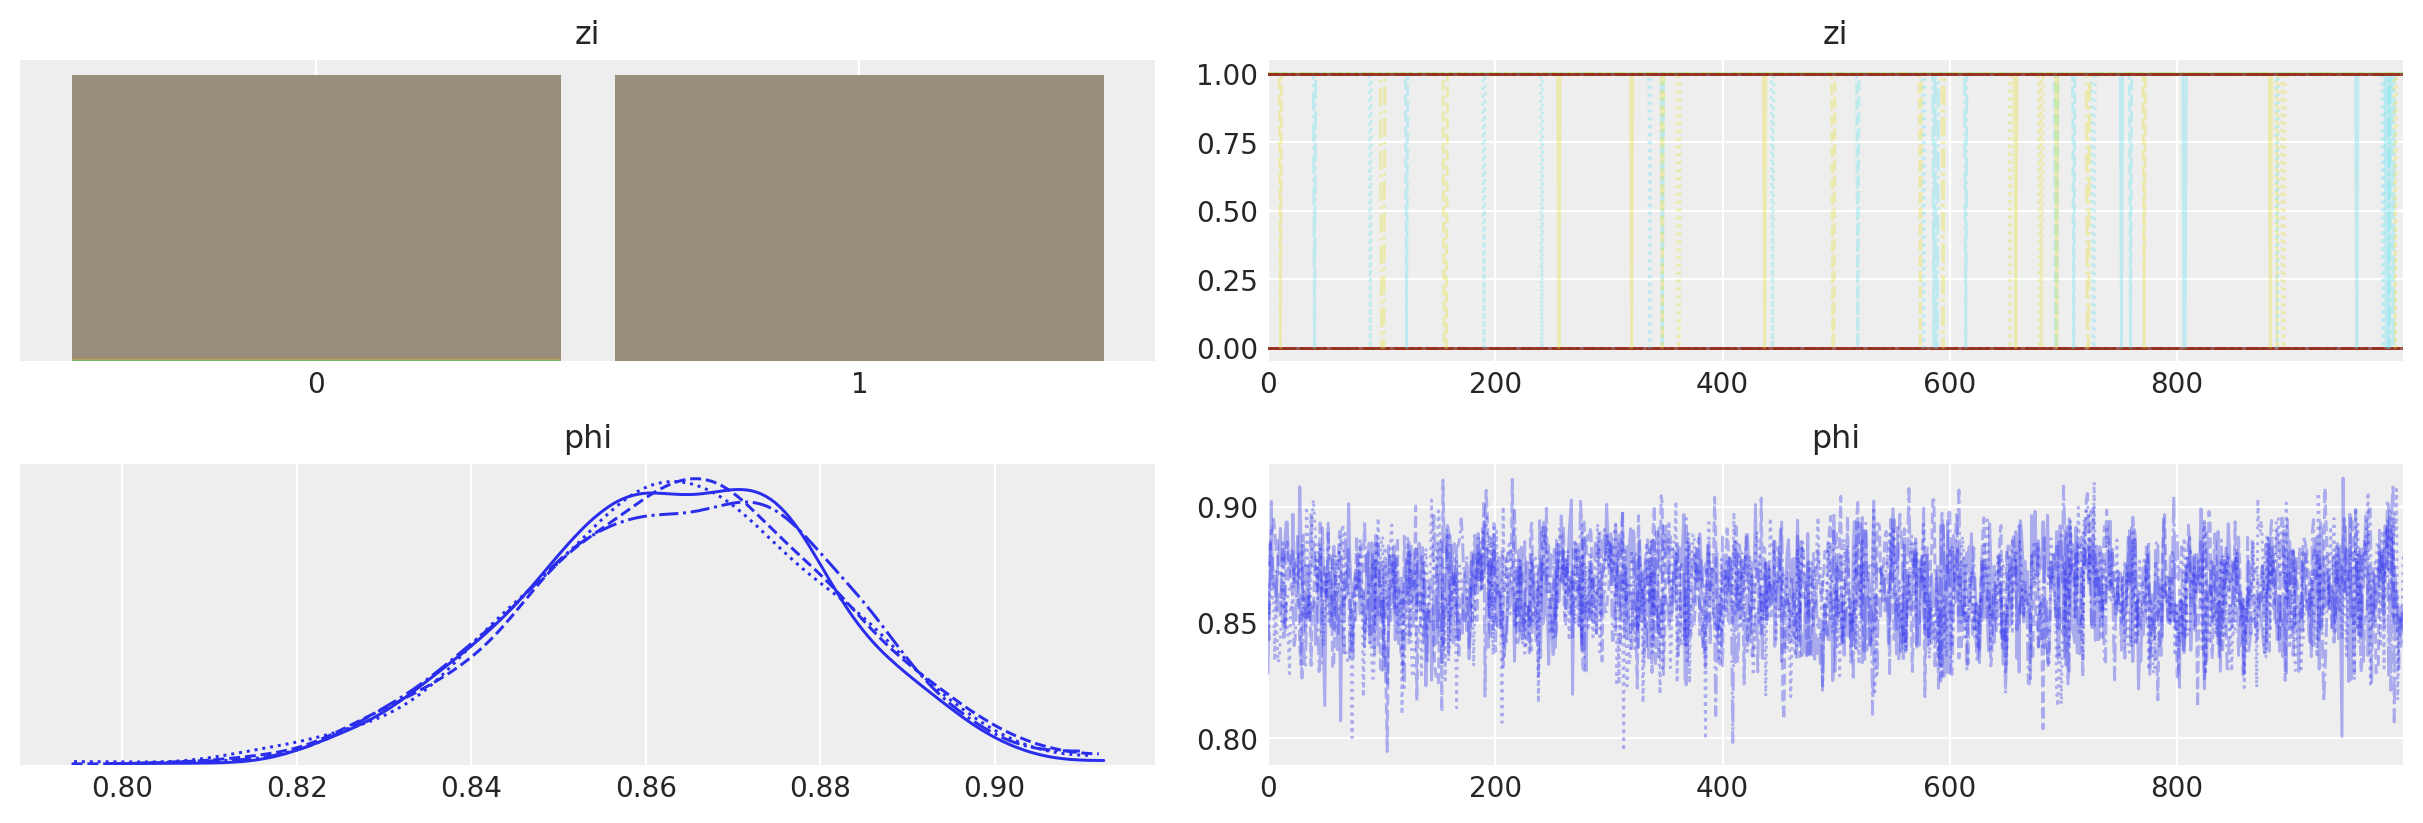

In [3]:
k = np.array([21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 36, 35])
p = len(k)  # number of people
n = 40  # number of questions

with pm.Model() as model1:
    # group prior
    zi = pm.Bernoulli("zi", p=0.5, shape=p)
    # accuracy prior
    phi = pm.Uniform("phi", upper=1, lower=0.5)
    psi = 0.5
    theta = pm.Deterministic("theta", phi * tt.eq(zi, 1) + psi * tt.eq(zi, 0))

    # observed
    ki = pm.Binomial("ki", p=theta, n=n, observed=k)

    trace1 = pm.sample()

ztrace = trace1["zi"]
print("Grouping", ztrace[-1, :])

az.plot_trace(trace1, var_names=["zi", "phi"], compact=True);

## 6.2 Exam scores with individual differences


$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \mu \sim \text{Uniform}(0.5, 1) $$
$$ \lambda \sim \text{Gamma}(.001, .001)$$  
$$ \phi_{i} \sim \text{Gaussian}(\mu, \lambda)_{\mathcal I(0,1)} $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi_{i}  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [phi, lambda_, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943299551313947, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.638612931542092, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


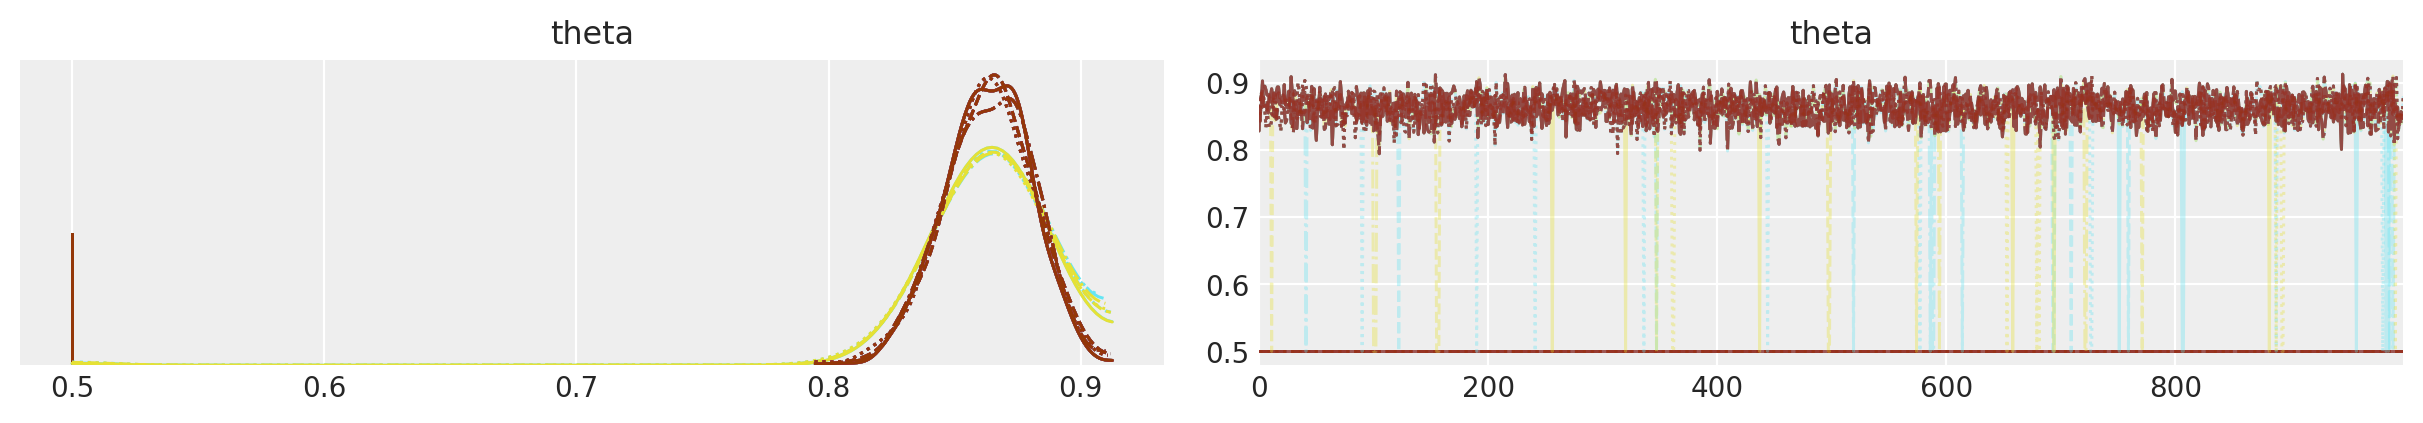

In [4]:
# pymc3 - need some tuning to get the same result as in JAGS
k = np.array([21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 36, 35])
p = len(k)  # number of people
n = 40  # number of questions

with pm.Model() as model2:
    # group prior
    zi = pm.Bernoulli("zi", p=0.5, shape=p)
    # accuracy prior
    psi = 0.5
    mu = pm.Uniform("mu", upper=1, lower=0.5)
    lambda_ = pm.Gamma("lambda_", alpha=0.001, beta=0.001)
    phi = pm.Bound(pm.Normal, 0, 1)("phi", mu=mu, tau=lambda_, shape=p)

    theta = pm.Deterministic("theta", tt.switch(tt.eq(zi, 1), phi, psi))

    # observed
    ki = pm.Binomial("ki", p=theta, n=n, observed=k)

    trace2 = pm.sample()

ztrace = trace2["zi"]
print("Grouping", ztrace[-1, :])

az.plot_trace(trace1, var_names=["theta"], compact=True);

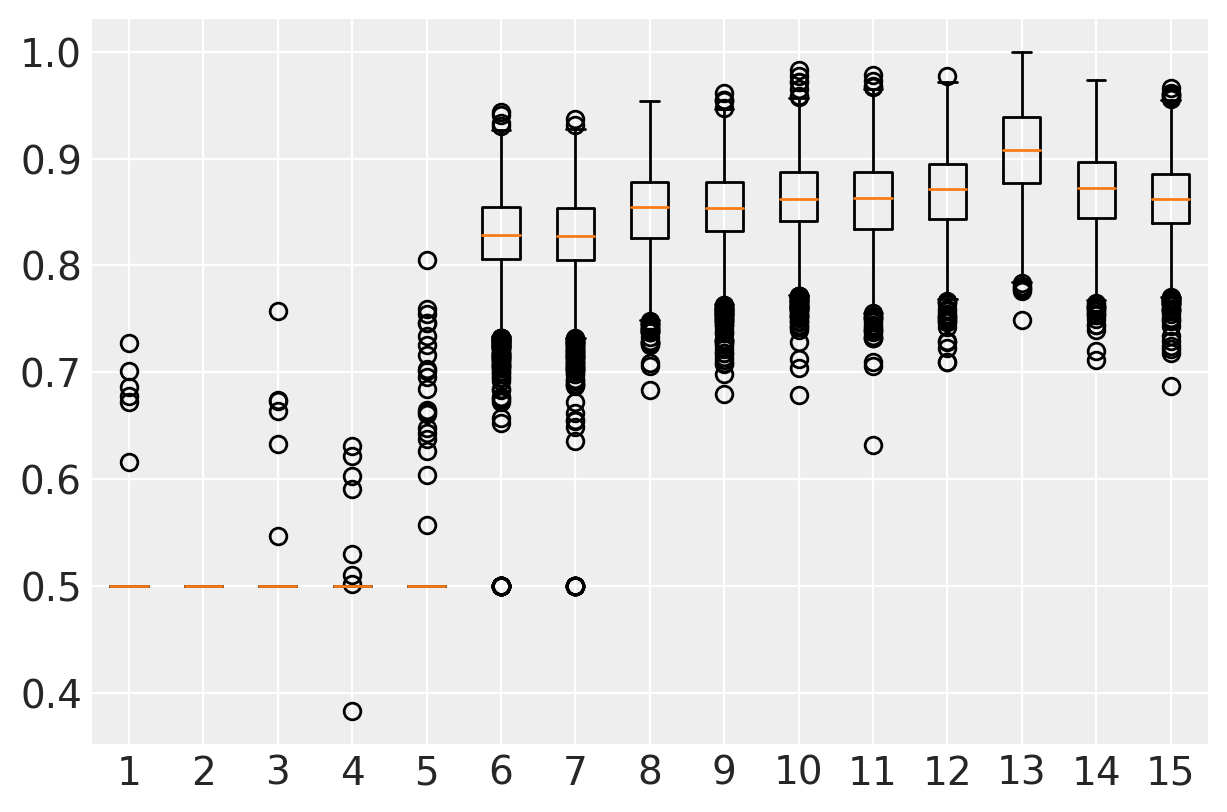

In [5]:
plt.figure()
plt.boxplot(trace2["theta"]);

## 6.3 Twenty questions


Suppose a group of 10 people attend a lecture, and are asked a set of 20 questions afterwards, with every answer being either correct or incorrect.  
$$ p_{i},q_{j} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = p_{i}q_{j} $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

In [6]:
dset = 2

if dset==1:
    k = np.array([
        1,1,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
    ]).reshape(10,-1)
elif dset==2:
    k = np.ma.masked_values([
        1,1,1,1,0,0,1,1,0,1,0,0,-999,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,-999,0,0
    ], value=-999).reshape(10,-1)

Np, Nq = k.shape

/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/pymc3/model.py:1515: ImputationWarning: Data in kij contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [qi, pi]
>BinaryGibbsMetropolis: [kij_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


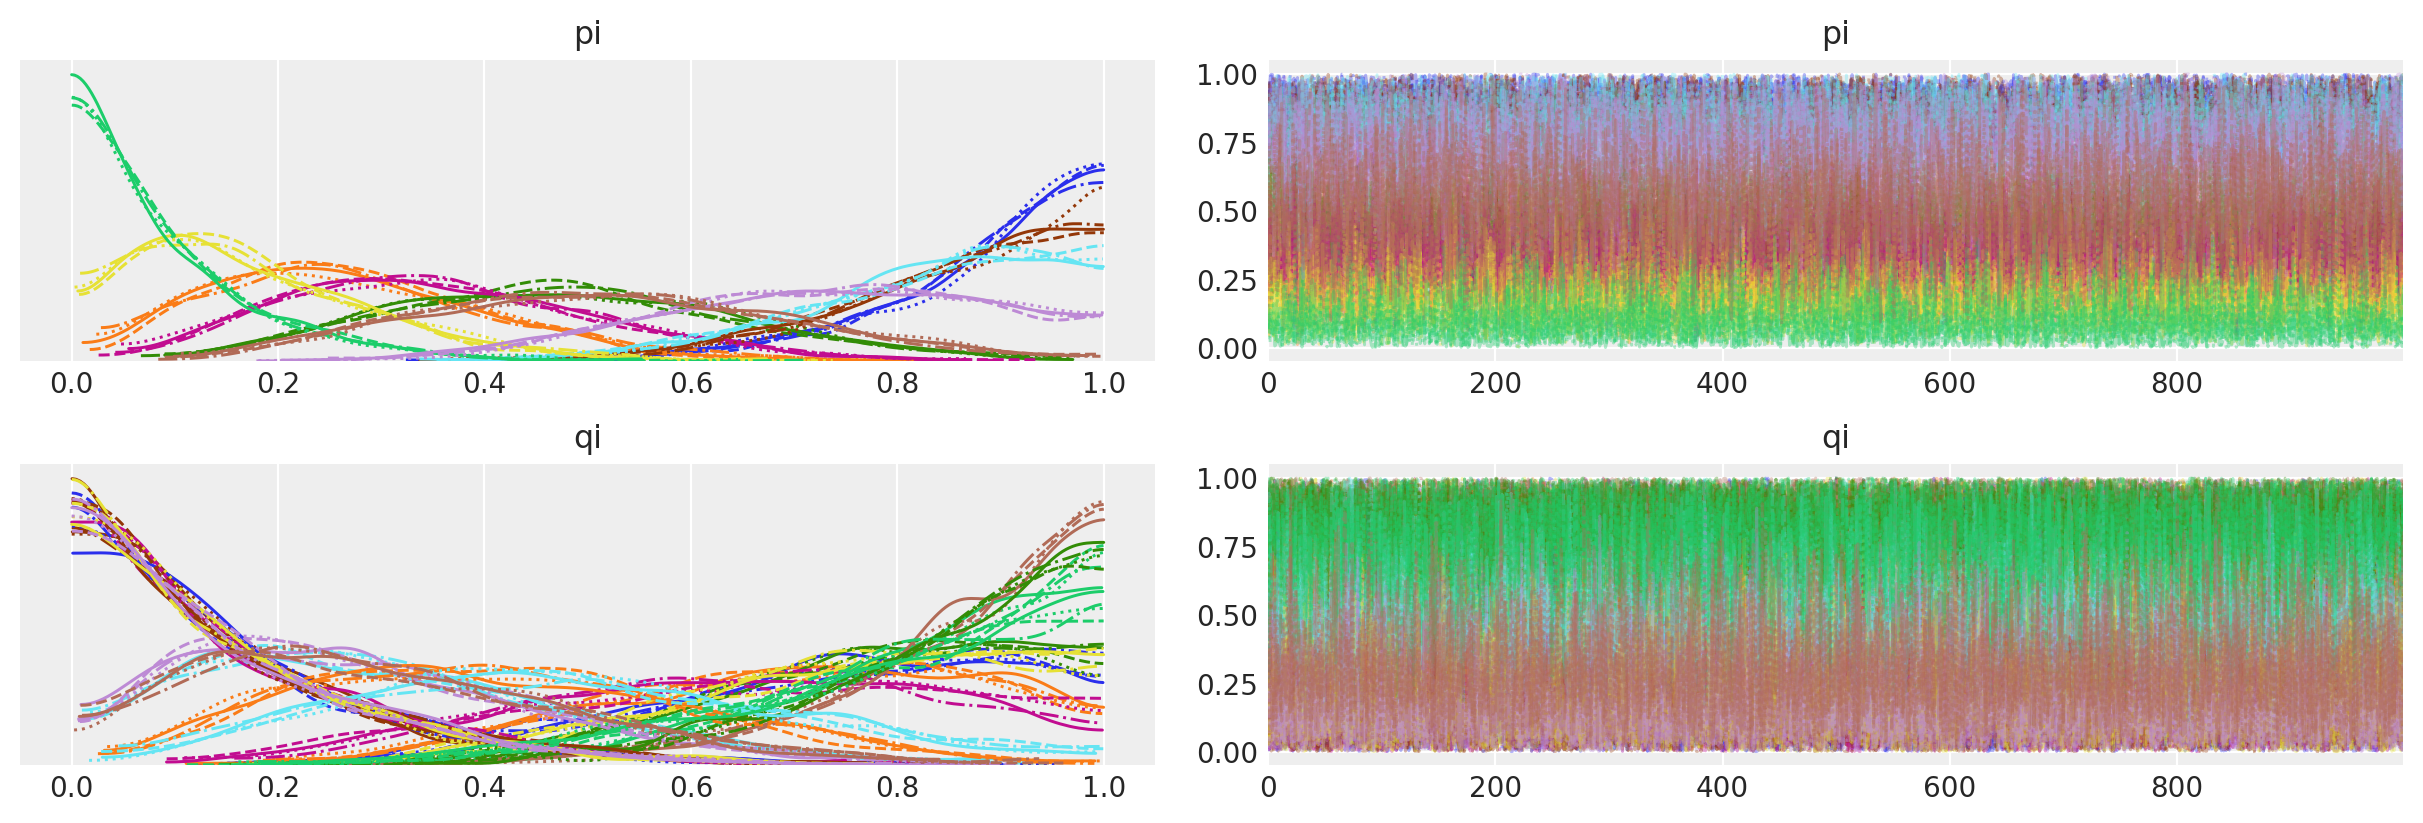

In [7]:
with pm.Model() as model3:
    # prior
    pi = pm.Beta("pi", alpha=1, beta=1, shape=Np)
    qi = pm.Beta("qi", alpha=1, beta=1, shape=Nq)
    # accuracy prior
    theta = pm.Deterministic("theta", tt.outer(pi, qi))
    # observed
    kij = pm.Bernoulli("kij", p=theta, observed=k)

    trace3 = pm.sample()

az.plot_trace(trace3, var_names=["pi", "qi"], compact=True);

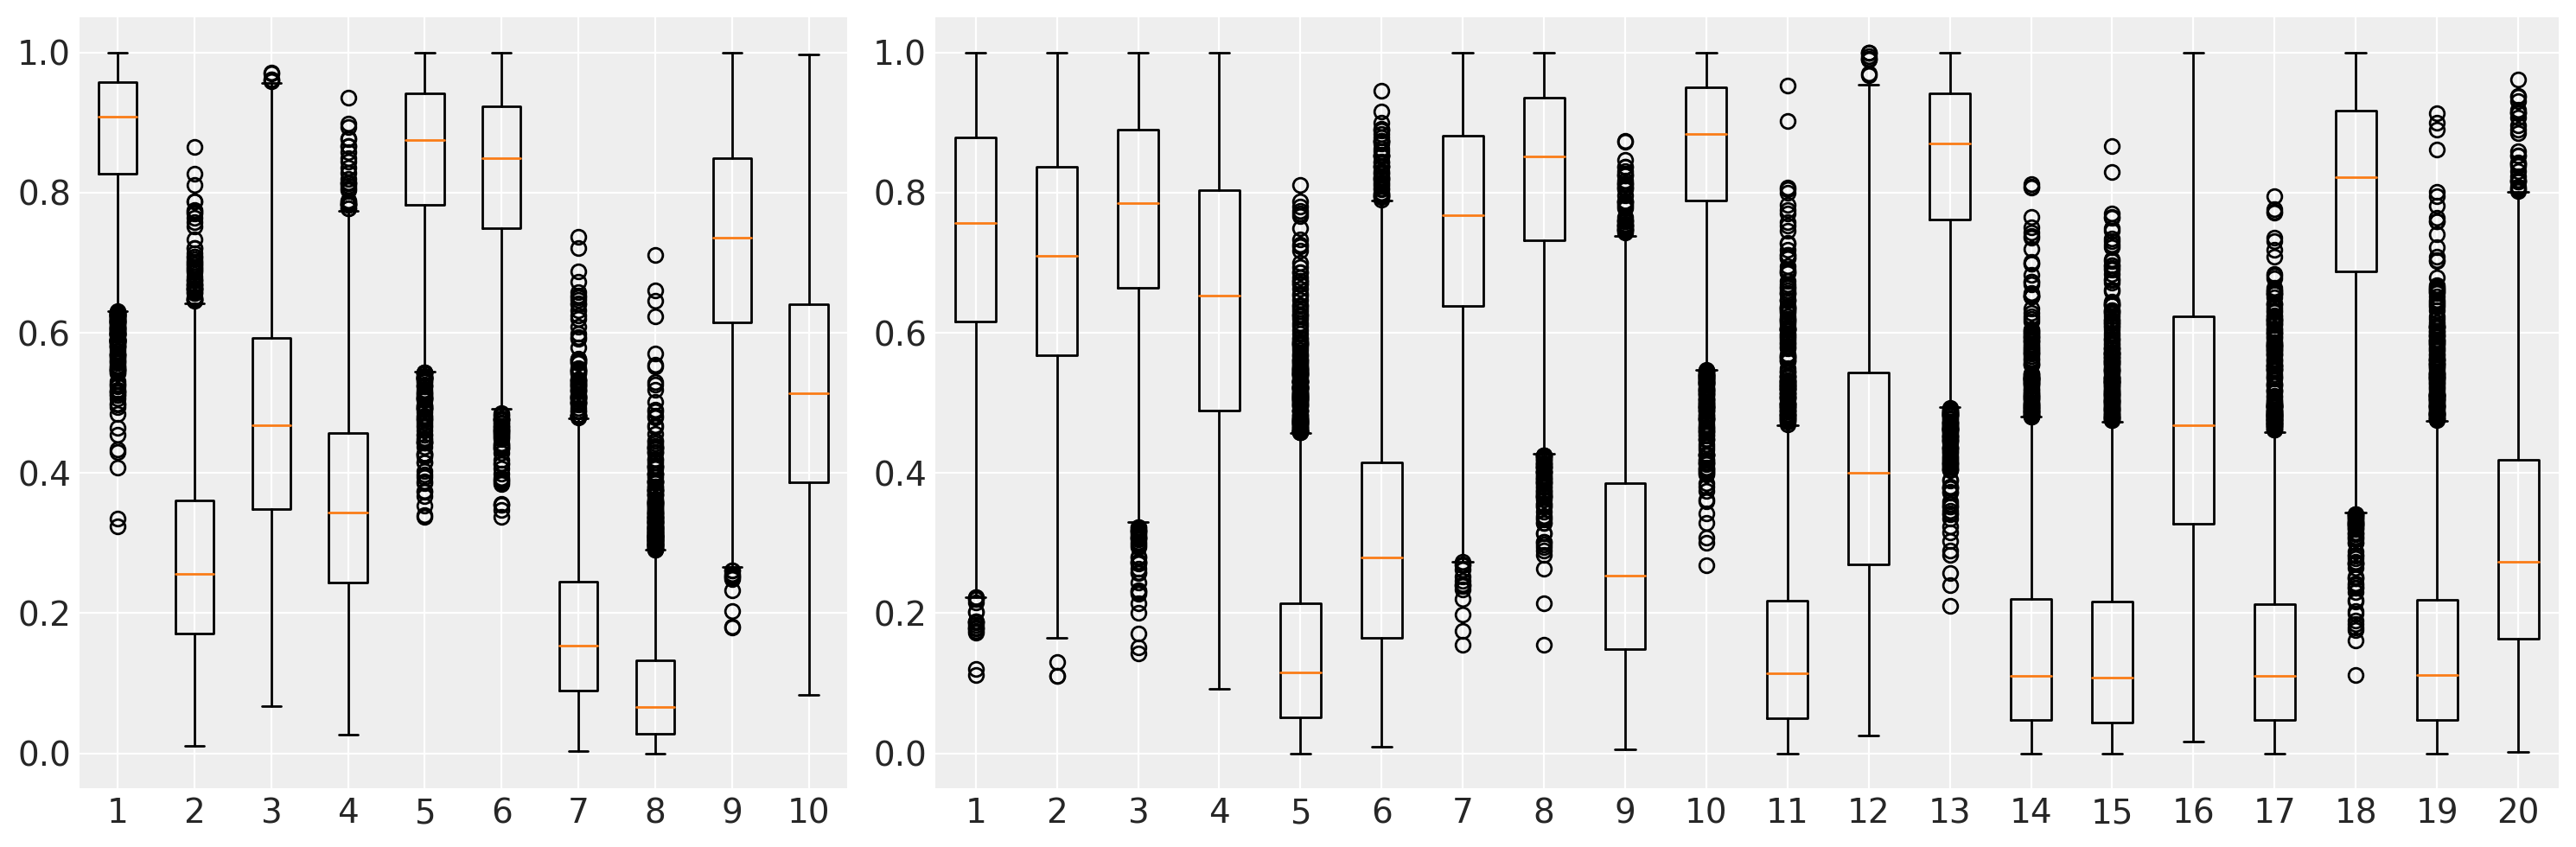

In [8]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

ax0 = plt.subplot(gs[0])
pipost = trace3["pi"]
ax0.boxplot(pipost)

ax1 = plt.subplot(gs[1:])
qipost = trace3["qi"]
ax1.boxplot(qipost)

plt.tight_layout();

## 6.4 The two-country quiz


$$ \alpha \sim \text{Uniform}(0,1) $$
$$ \beta \sim \text{Uniform}(0,\alpha) $$
$$ x_{i} \sim \text{Bernoulli}(0.5) $$
$$ z_{j} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\alpha  & \text{if $x_{i} = z_{j}$} \\
\beta  & \text{if $x_{i} \neq z_{j}$}
\end{cases}  $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

In [9]:
dset = 3

if dset==1:
    k = np.array([
        1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0
    ]).reshape(8,-1)
elif dset==2:
    k = np.ma.masked_values([
        1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999
    ], value=-999).reshape(11,-1)
elif dset==3:
    k = np.ma.masked_values([
        1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999
    ], value=-999).reshape(21,-1)

Nx, Nz = k.shape

/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/pymc3/model.py:1515: ImputationWarning: Data in kij contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>BinaryGibbsMetropolis: [xi, zj, kij_missing]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


xi [1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0]
zj [1 0 0 1 1 0 0 1]


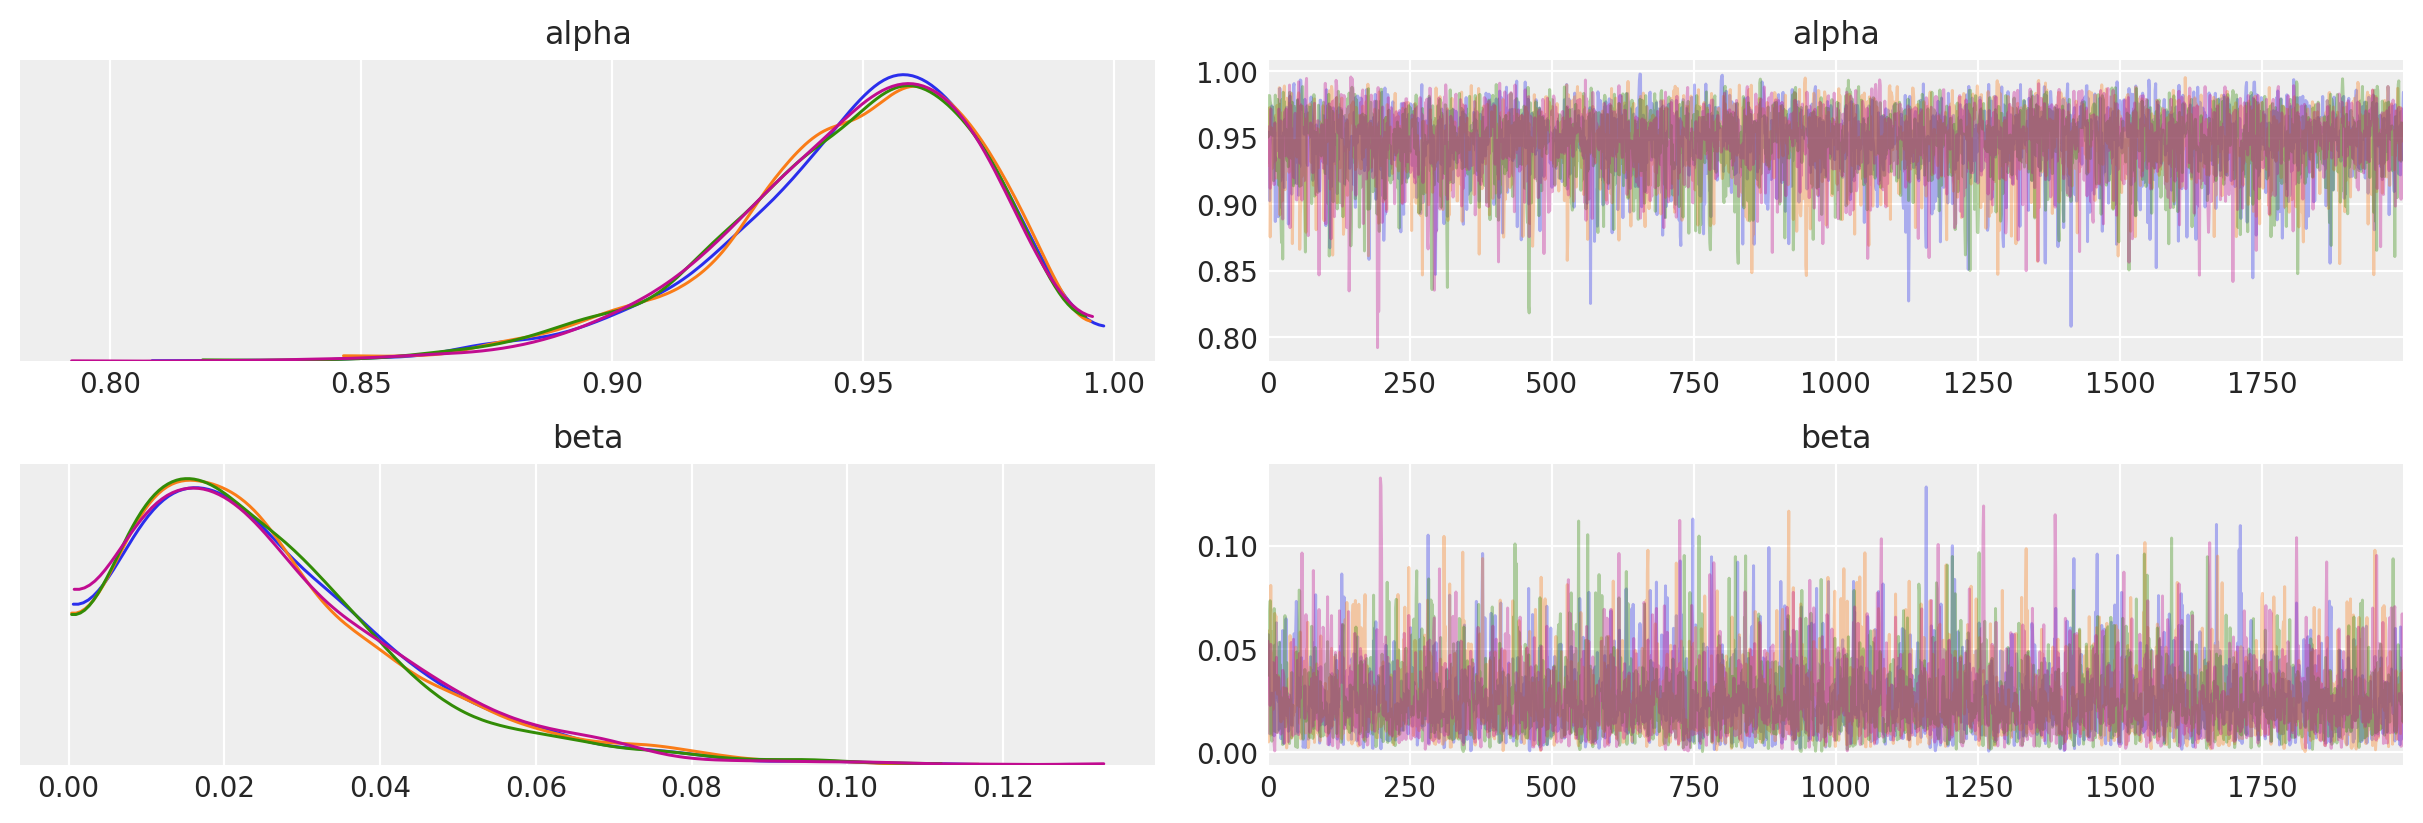

In [10]:
with pm.Model() as model4:
    # prior
    alpha = pm.Uniform("alpha", lower=0., upper=1.)
    beta = pm.Uniform("beta", lower=0., upper=alpha)

    xi = pm.Bernoulli("xi", p=0.5, shape=(Nx, 1))
    zj = pm.Bernoulli("zj", p=0.5, shape=(1, Nz))

    # accuracy prior
    theta = pm.Deterministic("theta", tt.switch(tt.eq(xi, zj), alpha, beta))

    # observed
    kij = pm.Bernoulli("kij", p=theta, observed=k)

    step = pm.Slice([alpha, beta])
    trace4 = pm.sample(2000, tune=2000, step=step)
    
xtrace = trace4["xi"]
print("xi", xtrace[-1, :].flatten())
ztrace = trace4["zj"]
print("zj", ztrace[-1, :].flatten())

az.plot_trace(trace4, var_names=["alpha", "beta"]);

## 6.5 Assessment of malingering


$$ \psi^b \sim \text{Uniform}(0.5,1) $$
$$ \psi^m \sim \text{Uniform}(0,\psi^b) $$
$$ z_{i} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\psi^b  & \text{if $z_{i} = 0$} \\
\psi^m  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 

In [11]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k)  # number of people
n = 45  # number of questions

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [psim, psib]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]


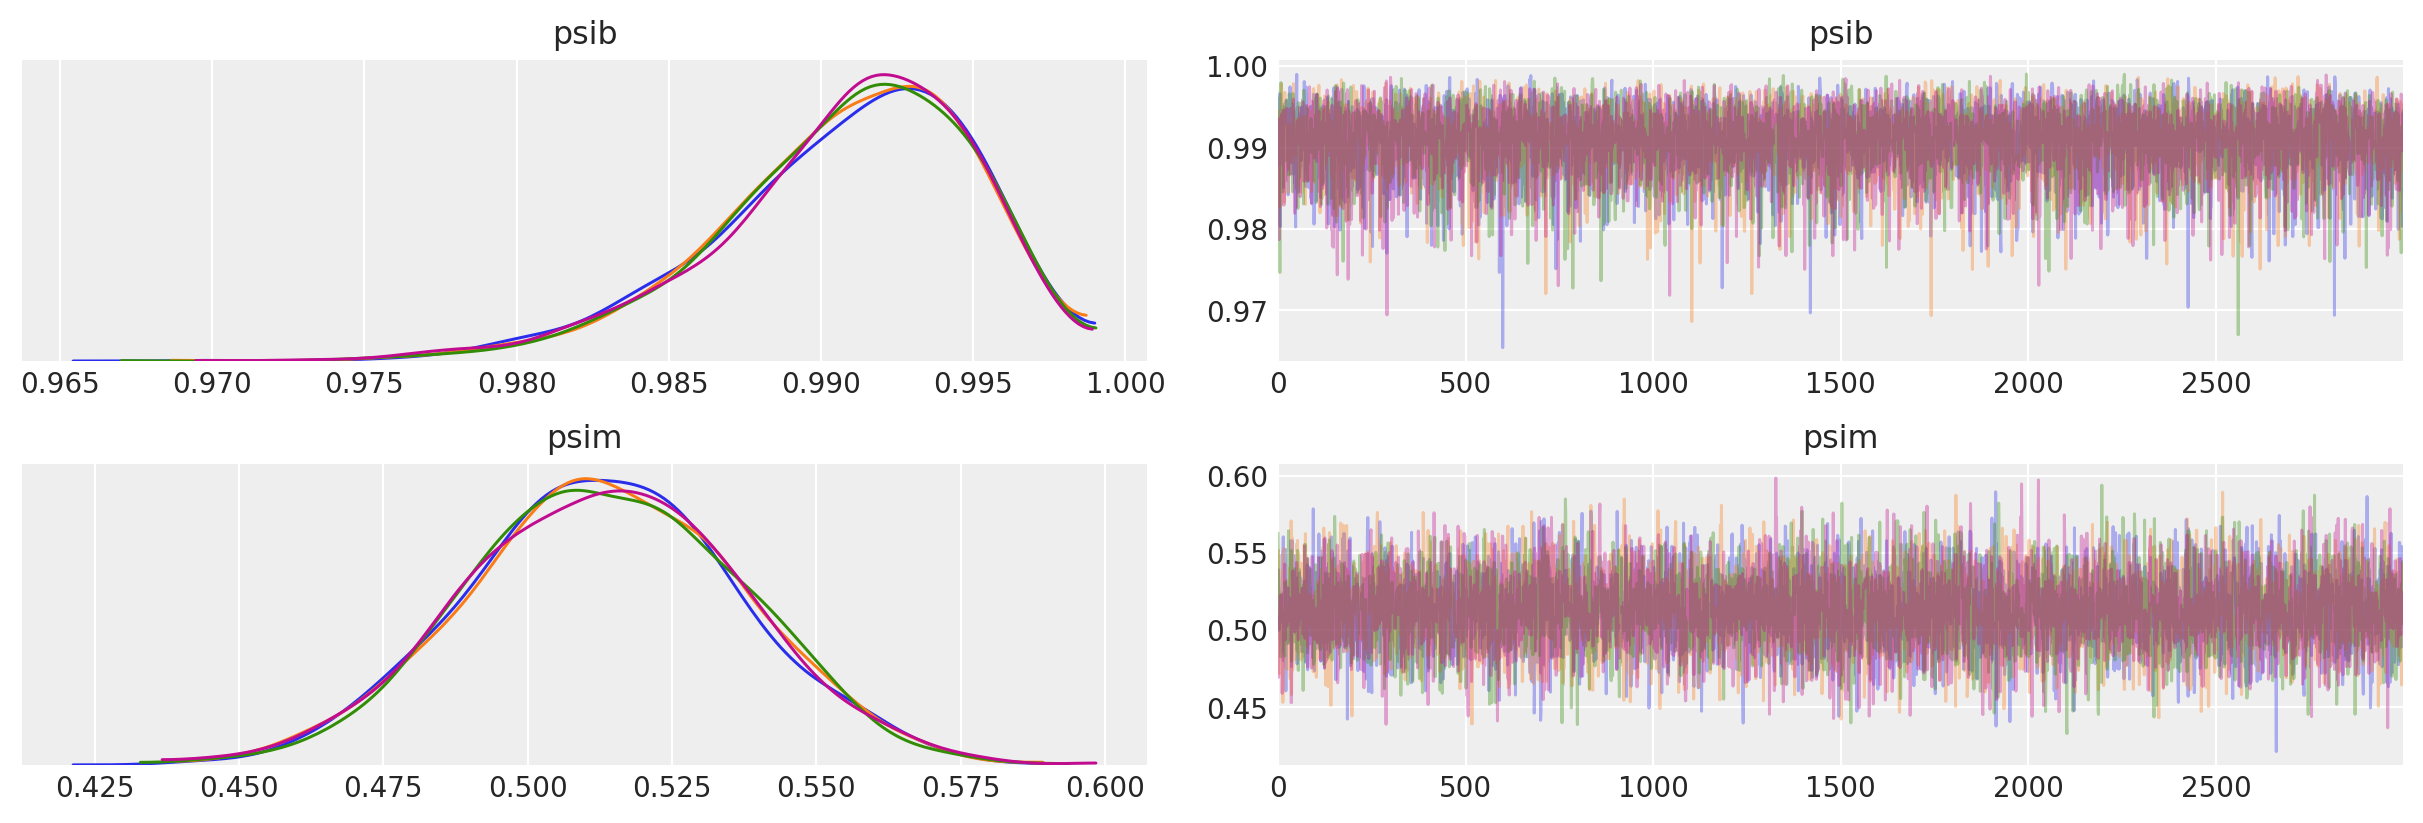

In [12]:
with pm.Model() as model5:
    # prior
    psib = pm.Uniform("psib", lower=0.5, upper=1.)
    psim = pm.Uniform("psim", lower=0., upper=psib)

    zi = pm.Bernoulli("zi", p=0.5, shape=p)

    theta = pm.Deterministic("theta", tt.switch(tt.eq(zi, 0), psib, psim))

    # observed
    kij = pm.Binomial("kij", p=theta, n=n, observed=k)

    trace5 = pm.sample(3000)

ztrace = trace5["zi"]
print("zi-last", ztrace[-1, :])
print("zi-mode", stats.mode(ztrace[:], axis=0).mode.squeeze())

az.plot_trace(trace5, var_names=["psib", "psim"]);

## 6.6 Individual differences in malingering


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(40,800) $$
$$ \lambda_{m} \sim \text{Uniform}(4,100) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{m}\lambda_{m},(1-\mu_{m})\lambda_{m})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{m} = \text{logit}\mu_{b} - \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [13]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta2, theta1, psi, lambdam, lambdab, mud, mub]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), count=array([[4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000,
        4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]]))


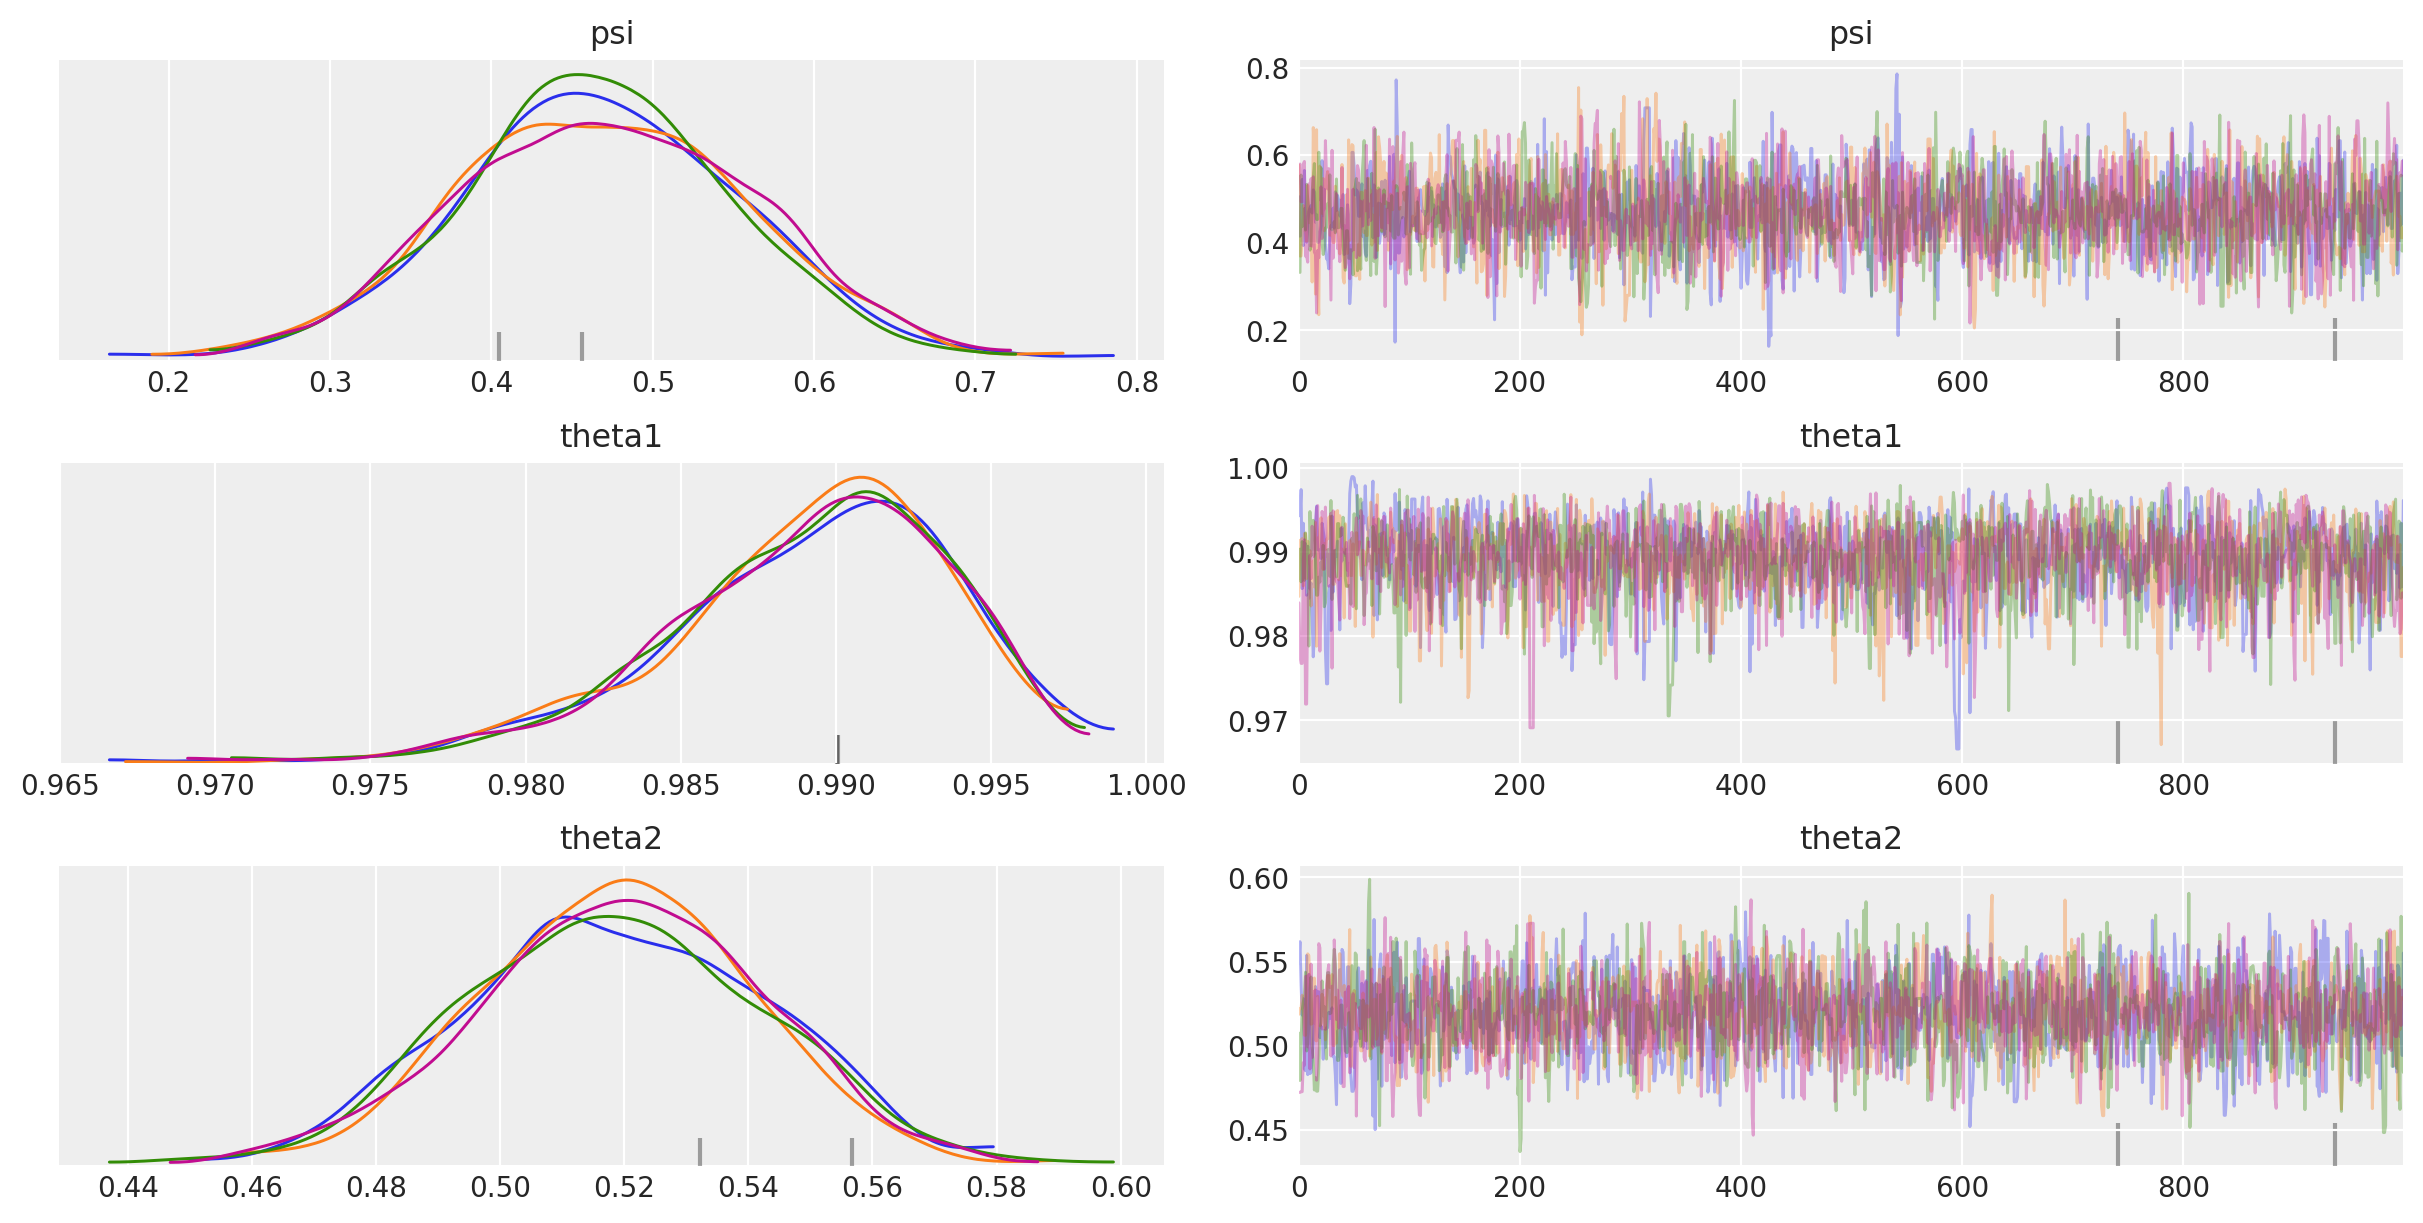

In [14]:
with pm.Model() as model6:
    # prior
    mub = pm.Beta("mub", alpha=1, beta=1)
    mud = pm.HalfNormal("mud", sd=0.5)
    lambdab = pm.Uniform("lambdab", lower=40, upper=800)
    lambdam = pm.Uniform("lambdam", lower=4, upper=100)
    psi = pm.Beta("psi", alpha=5, beta=5)

    zi = pm.Bernoulli("zi", p=psi, shape=p)

    mum = pm.Deterministic("mum", 1 / (1 + tt.exp(tt.log(1 / mub - 1) + mud)))
    theta1 = pm.Beta("theta1", alpha=mub * lambdab, beta=(1 - mub) * lambdab)
    theta2 = pm.Beta("theta2", alpha=mum * lambdam, beta=(1 - mum) * lambdam)

    theta = pm.Deterministic("theta", tt.switch(tt.eq(zi, 0), theta1, theta2))

    # observed
    kij = pm.Binomial("kij", p=theta, n=n, observed=k)
    trace6 = pm.sample()

ztrace = trace6["zi"]
print("zi-last", ztrace[-1, :])
print("zi-mode", stats.mode(ztrace[:], axis=0))

az.plot_trace(trace6, var_names=["psi", "theta1", "theta2"]);

## 6.7 Alzheimer's recall test cheating


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(5,50) $$
$$ \lambda_{c} \sim \text{Uniform}(5,50) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{c}\lambda_{c},(1-\mu_{c})\lambda_{c})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{c} = \text{logit}\mu_{b} + \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [15]:
# Load data
dat = pd.read_csv("cheat.csv", header=None)
truth = pd.read_csv("cheatt.csv", header=None)
k = np.array(dat.sum(axis=1))
t1 = truth.values.T

p = len(k)  # number of people
n = 40  # number of questions

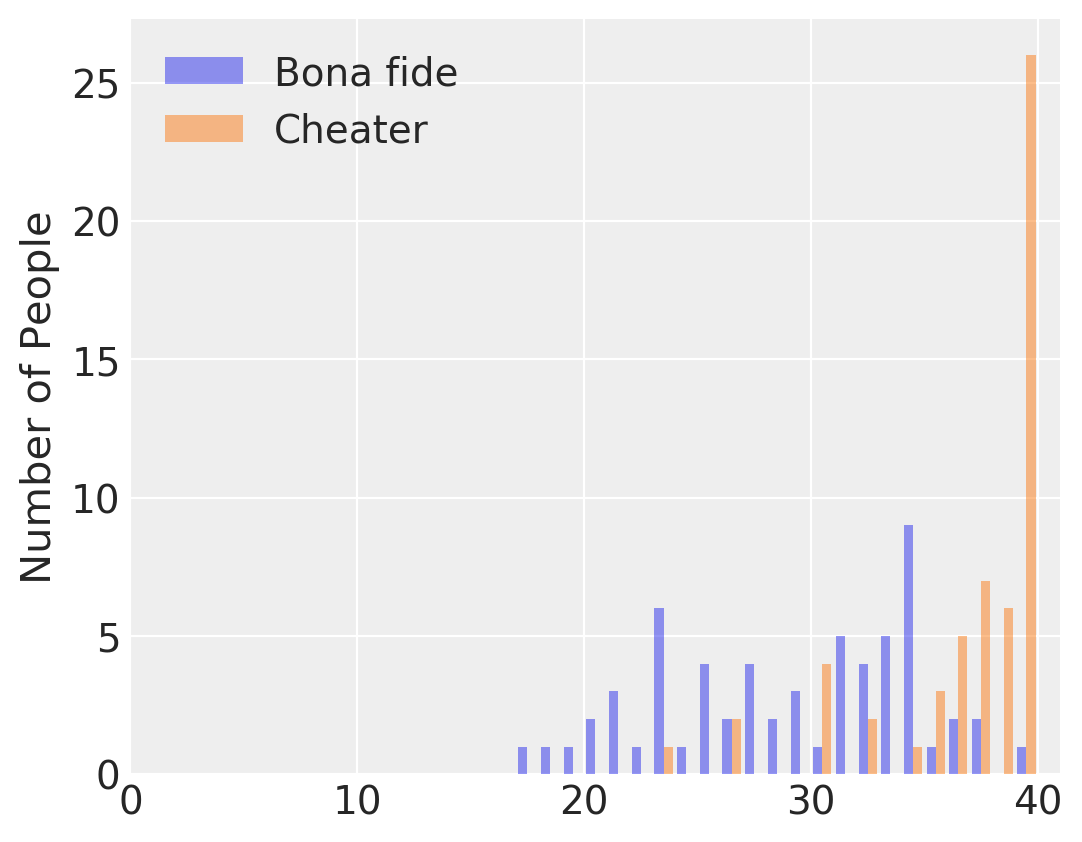

In [16]:
fig = plt.figure(figsize=(6, 5))
bins = np.arange(0, n + 1)
plt.hist(
    [k[t1[0, :] == 0], k[t1[0, :] == 1]],
    bins,
    alpha=0.5,
    label=["Bona fide", "Cheater"],
)
plt.xlim([0, 41])
plt.legend(loc="upper left")
plt.ylabel("Number of People");

In [17]:
with pm.Model() as model7:
    # prior
    mub = pm.Beta("mub", alpha=1, beta=1)
    mud = pm.HalfNormal("mud", sd=0.5)
    lambdab = pm.Uniform("lambdab", lower=5, upper=50)
    lambdac = pm.Uniform("lambdac", lower=5, upper=50)
    psi = pm.Beta("psi", alpha=5, beta=5)
    # psi = pm.Uniform("psi",lower=0,upper=1)
    zi = pm.Bernoulli("zi", p=psi, shape=p)

    muc = pm.Deterministic("muc", 1 / (1 + tt.exp(tt.log(1 / mub - 1) - mud)))
    theta1 = pm.Beta("theta1", alpha=mub * lambdab, beta=(1 - mub) * lambdab)
    theta2 = pm.Beta("theta2", alpha=muc * lambdac, beta=(1 - muc) * lambdac)

    theta = pm.Deterministic("theta", tt.switch(tt.eq(zi, 1), theta1, theta2))

    # observed
    kij = pm.Binomial("kij", p=theta, n=n, observed=k)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta2, theta1, psi, lambdac, lambdab, mud, mub]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8827854763199589, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


zi [1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0
 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 1 0 0 0 1 1]
zi ModeResult(mode=array([[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1]]), count=array([[9000, 9000, 9000, 7544, 8999, 9000, 8963, 8439, 9000, 8893, 9000,
        9000, 9000, 9000, 9000, 9000, 7532, 8997, 8999, 8997, 6741, 8986,
        8983, 8878, 9000, 7507, 8999, 9000, 9000, 9000, 8700, 9000, 8998,
        9000, 8920, 8996, 9000, 7527, 6711, 9000, 8949, 8695, 9000, 8993,
        9000, 9000, 9000, 8986

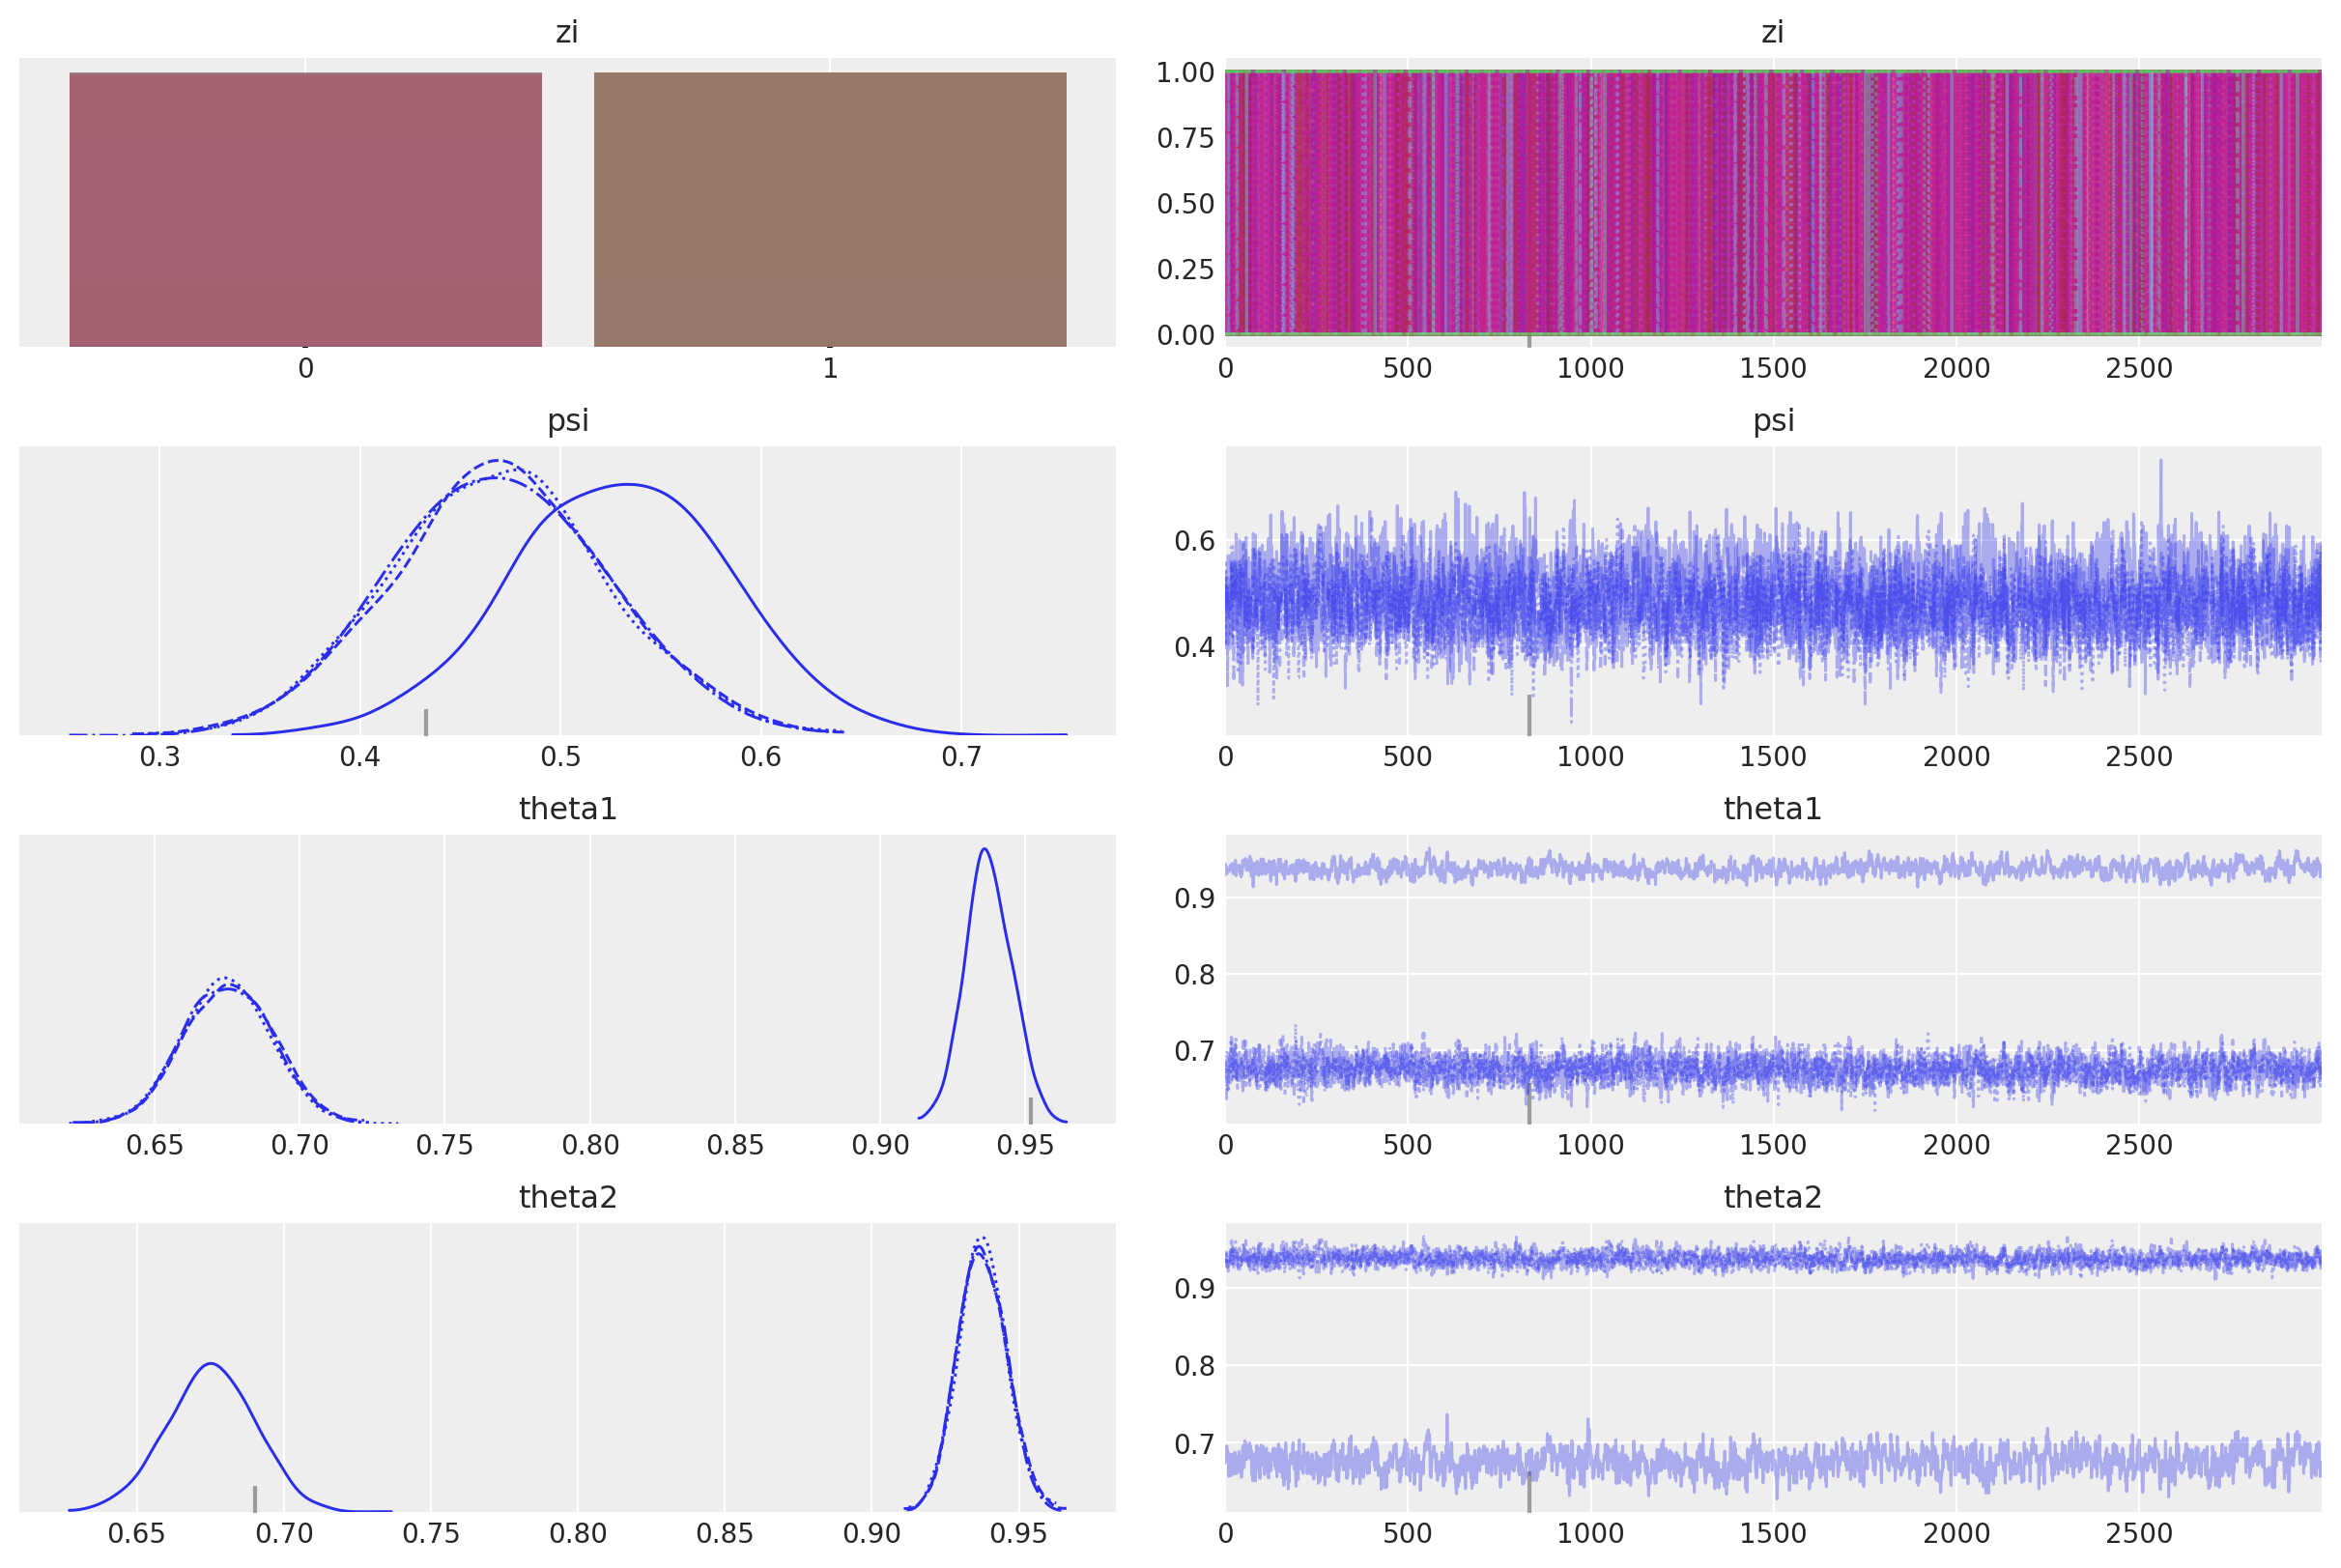

In [18]:
with model7:
    start = pm.find_MAP()
    start['zi'] = np.random.binomial(1, .5, p)
    trace7 = pm.sample(3000, tune=2000, start=start, init=None)

ztrace = trace7['zi']
print('zi', ztrace[-1, :])
print('zi', stats.mode(ztrace[:], axis=0))
print(np.mean(ztrace[-1:] == (t1[0, :] == 1)))

az.plot_trace(trace7, var_names=["zi", "psi", "theta1", "theta2"], compact=True);

0.19491525423728814


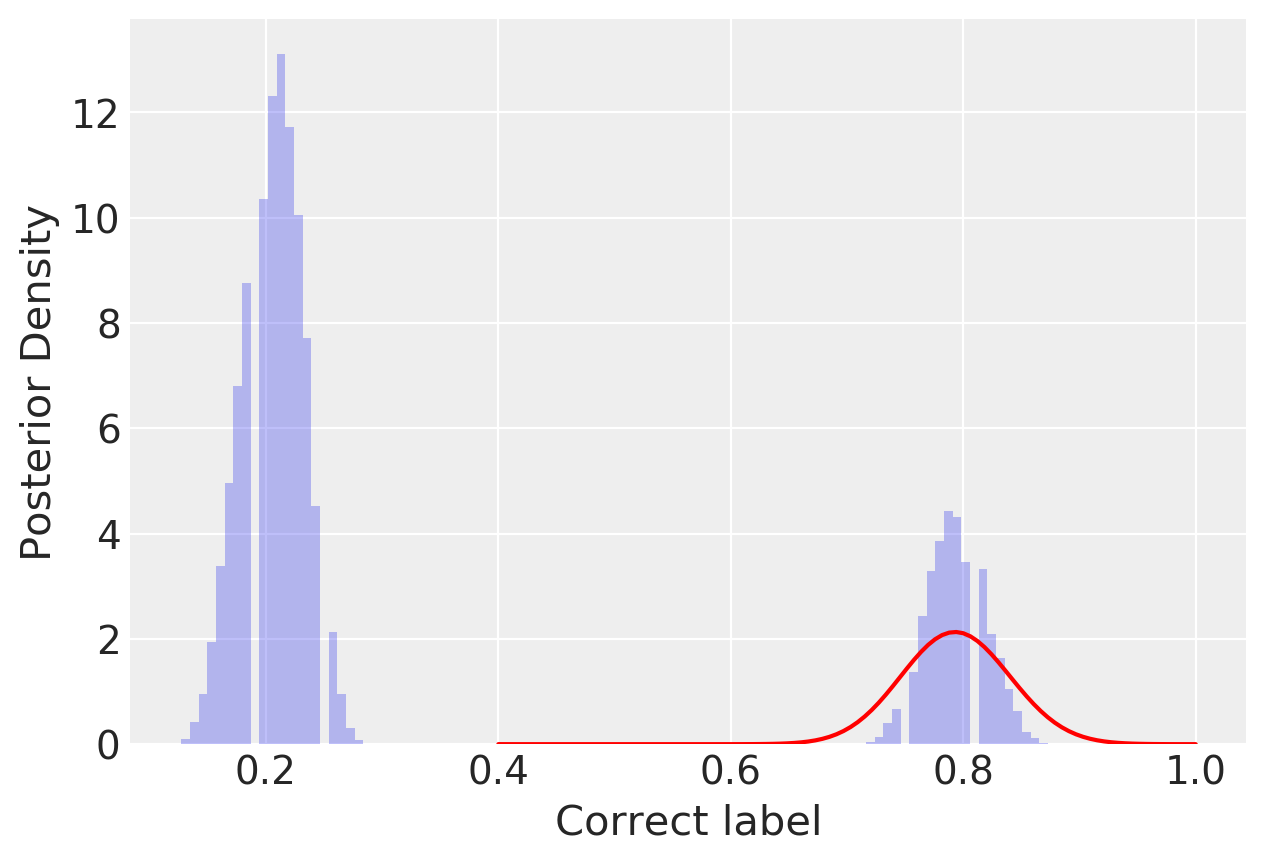

In [19]:
ztrace = trace7["zi"]

print(np.mean(ztrace[-1:] == (t1[0, :] == 1)))
pc = np.mean(ztrace == (t1[0, :] == 1), axis=1)

my_pdf = stats.kde.gaussian_kde(pc)
x = np.linspace(0.4, 1, 100)
plt.plot(x, my_pdf(x), "r")  # distribution function
plt.hist(pc, bins=100, density=1, alpha=0.3)
plt.xlabel("Correct label")
plt.ylabel("Posterior Density");

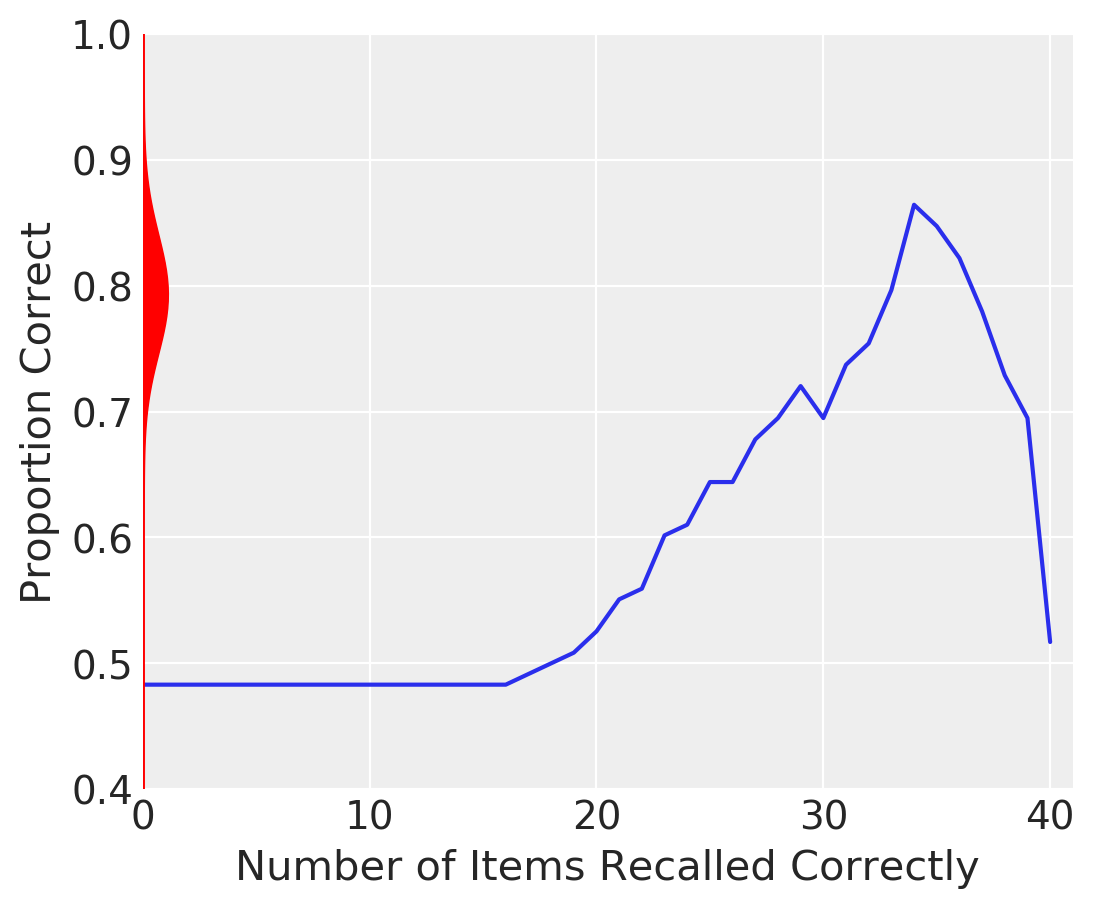

In [20]:
fig = plt.figure(figsize=(6, 5))

my_pdf = stats.kde.gaussian_kde(pc)
x = np.linspace(0.4, 1, 100)
tmp = np.zeros(n + 1)

for i in range(n + 1):
    tmp[i] = np.mean((k > i) == (t1[0, :] == 1))

plt.plot(tmp)
pdfpc = my_pdf(x) / 2
plt.plot(pdfpc, x, "r")

plt.fill_between(pdfpc, x, 0, color="r")
plt.axis([0, 41, 0.4, 1])
plt.xlabel("Number of Items Recalled Correctly")
plt.ylabel("Proportion Correct");

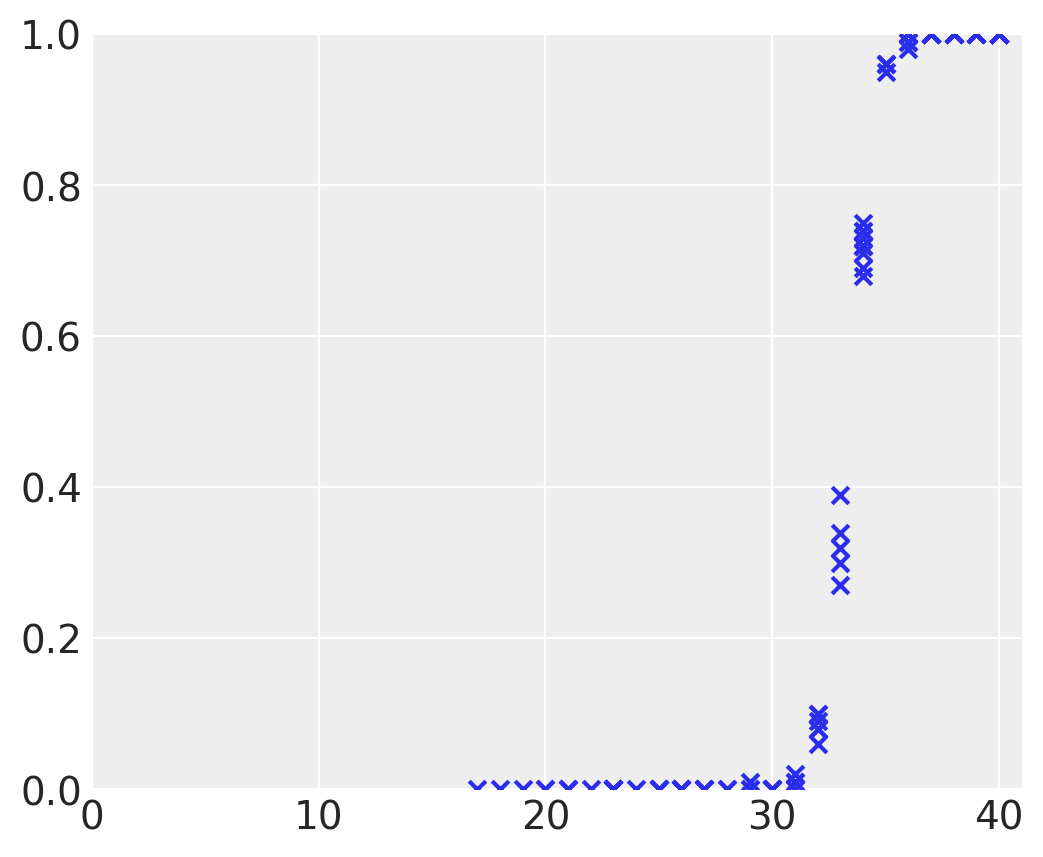

In [21]:
pc2 = np.mean(ztrace[0:100], axis=0)
plt.figure(figsize=(6, 5))
plt.scatter(k, pc2, marker="x")
plt.axis([0, 41, 0, 1]);

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy  1.18.1
pandas 1.0.3
arviz  0.7.0
pymc3  3.8
last updated: Sat Apr 25 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
